# [NTDS'18] Final project
[ntds'18]: https://github.com/mdeff/ntds_2018

* Team: `4` ([github repo](https://github.com/swouf/ntds_IMDb_team4))
* Dataset: `IMDb Films and Crew`

### Authors :
+ [Julien Berger](mailto:juliengaetan.berger@epfl.ch)
+ [Jérémy Jayet](mailto:jeremy.jayet@epfl.ch)
+ [Hana Samet](mailto:hana.samet@epfl.ch)
+ [Mathieu Shiva](mailto:mathieu.shiva@epfl.ch)

## 0 - Import packages and data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx
import logging
import json
import sys
import seaborn as sns
import collections

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import src.load_data as ldata

## 1 - Clean the initial dataset and explore it

The initial dataset is composed of two csv files. One contains informations about the movies, as seen in the cell below. It initialy contains 4803 movies, and 20 columns

In [2]:
initial_movies = pd.read_csv('./data/tmdb_5000_movies.csv')
print(initial_movies.shape)
initial_movies.head(3)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",10/12/2009,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",19/05/2007,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",26/10/2015,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


The second csv file contains informations about the cast and the crew of all 4803 movies. The information is stored in json columns.

In [3]:
initial_credits = pd.read_csv('./data/tmdb_5000_credits.csv')
print(initial_credits.shape)
initial_credits.head(3)

(4803, 4)


,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


As both csv files contain columns that have a json format, we first have to expend them. This is achieved by our function load_dataframe, which returns a cleaner version of the movies dataframe and a "people" dataframe that contains an extended list of the people in the dataset.

In [4]:
(movies,people) = ldata.load_dataframes();

2019-01-17 11:45:45,062 | INFO : Data loaded !


For the movies dataframe, we removed movies that were missing information about their revenue or their budget, thus we only have 3229 movies left. We expended the genre column which was previously a json column, and assigned and id to each genre (present in the column "genre"). The name of the genre is kept in the column "genres_names". We added the return on investment under the "ROI" column ($ROI=\frac{revenue-budget}{budget}$), and a success column which has a value of 1 if the ROI of the movie is superior to 1 and a value of 0 otherwise. We also changed the ID of the movies, by changing to values between 0 and 4802.

In [5]:
print(movies.shape)
movies.head(3)

(3229, 23)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genres_names,ROI,success
0,237000000,0,http://www.avatarmovie.com/,0,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action,10.763566,1.0
1,300000000,1,http://disney.go.com/disneypictures/pirates/,1,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Adventure,2.203333,1.0
2,245000000,0,http://www.sonypictures.com/movies/spectre/,2,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,Action,2.594590,1.0


For the people dataframe, we expended the json format and made a list that contains 1 row for each role or job. Their are 193655 rows (combination of actor or crew and their job in the movie), but only 87106 unique people (for example if Bruce Willis played 10 different roles, their will be 10 different rows for Bruce Willis, but each one will have a unique id.).

In [6]:
print(people.shape)
print(people['name'].unique().shape)
people.head(3)

(193655, 11)
(87106,)


,cast_id,character,credit_id,gender,id,movie_id,name,order,type,department,job
0,242.0,Jake Sully,5602a8a7c3a3685532001c9a,2,65731,0,Sam Worthington,0,cast,NaN,NaN
1,3.0,Neytiri,52fe48009251416c750ac9cb,1,8691,0,Zoe Saldana,1,cast,NaN,NaN
2,25.0,Dr. Grace Augustine,52fe48009251416c750aca39,1,10205,0,Sigourney Weaver,2,cast,NaN,NaN


We then realized that only a few of the ROI had high values (above 10), while the rest of the movies had values very close to 1, which created issues when we wanted to plot them. We thus filtered them.

In [7]:
print('The 10 largest ROI are \n {}'.format(movies['ROI'].nlargest(10)))
print('The number of ROI values which are larger than 10 is {}'.format(movies['ROI'][movies['ROI']>10].count()))
print('The average ROI is {}'.format(movies['ROI'].mean()))
print('The median ROI is {}'.format(movies['ROI'].median()))

The 10 largest ROI are 
 4577    12889.386667
4582     5329.339450
4496     4132.333333
4724      699.000000
4788      499.000000
4742      438.616585
4723      425.644100
4514      419.522723
3159      362.047059
4441      310.709965
Name: ROI, dtype: float64
The number of ROI values which are larger than 10 is 240
The average ROI is 11.737138980929341
The median ROI is 1.2990467222222222


In [8]:
filter_ROI=movies['ROI'].copy()
filter_ROI[filter_ROI>10]=10
movies['ROI']=filter_ROI

We created a list that allowed to make the conversion between the movies genres and the genre ID that we assigned them

In [10]:
list_genres=movies[['genres_names','genres']].copy()
list_genres=list_genres.drop_duplicates()
list_genres=list_genres.set_index('genres') 
list_genres

,genres_names
genres,
0,Action
1,Adventure
2,Fantasy
3,Animation
4,Science Fiction
5,Drama
6,Thriller
7,Family
8,Comedy


We plotted at the histograms for the budget, the revenue and the ROI, and observed that they all had tails-like distributions. Additionaly, for the ROI, it is important to note that a fair amount of movies havenegative values, meaning that had revenues that were smaller than their budget.

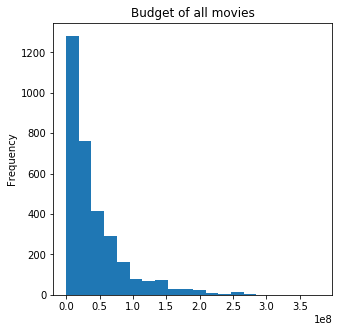

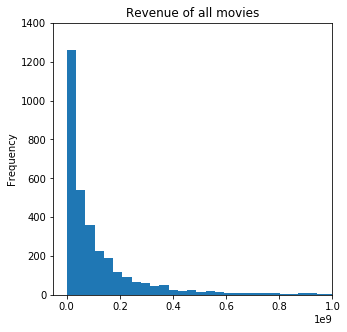

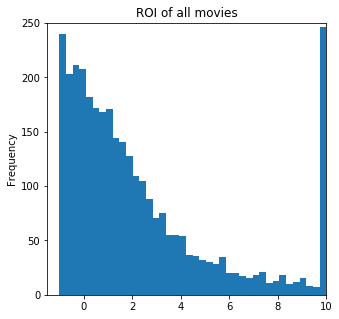

In [17]:
fig=plt.figure(figsize = (5,5))
movies.budget.plot(kind='hist', bins = 20)
plt.title('Budget of all movies')
plt.show()
fig.savefig('./pictures/budgets.png')

fig2=plt.figure(figsize = (5,5))
movies.revenue.plot(kind='hist', bins = 80)
plt.title('Revenue of all movies')
plt.axis([-0.05e9,1e9,0,1400])
plt.show()
fig2.savefig('./pictures/revenue.png')

fig3=plt.figure(figsize = (5,5))
movies.ROI.plot(kind='hist', bins = 40)
plt.title('ROI of all movies')
plt.axis([-1.5,10,0,250])
plt.show()
fig3.savefig('./pictures/roi.png')

We then looked at the different genres that we had, and looked at their repartition. We see that although their are 20 genres present in the dataset, only 7 genres have more than 100 movies. Drama, Comedy and Action represent 61% of the movies.

In [19]:
print(movies['genres_names'].value_counts())

Drama              747
Comedy             634
Action             588
Adventure          288
Horror             197
Crime              141
Thriller           118
Animation           99
Fantasy             93
Science Fiction     79
Romance             70
Family              38
Documentary         30
Mystery             27
Western             22
Music               20
History             18
War                 18
Foreign              1
Unknown              1
Name: genres_names, dtype: int64


C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\matplotlib\legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


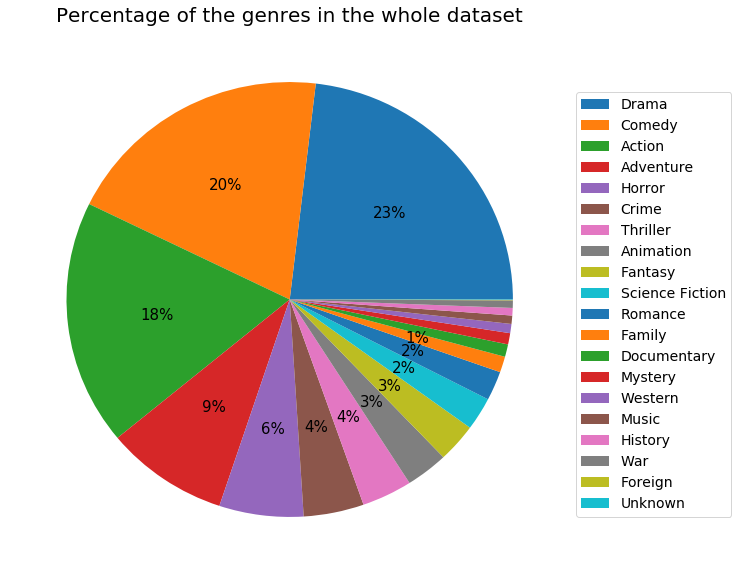

In [27]:
fig=plt.figure(figsize = (10,10))
plt.pie(data, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',labeldistance=1.1,startangle=0,textprops={'fontsize': 15})
plt.title('Percentage of the genres in the whole dataset',fontsize=20)
plt.legend(data,labels=movies['genres_names'].value_counts().index, bbox_to_anchor=(0.9,0.80), bbox_transform=plt.gcf().transFigure,prop={'size': 14})
plt.show()
fig.savefig('./pictures/pie.png')

## 2 - Create the feature matrix and a graph using the actors

We wanted to create a graph of movies by connecting them if they had similar actors. For that we created a function that uses the movies and the people dataframes, and return a dataframe with one row for each person. The first three columns contain the ID of the person, their name and the average rating of all their movies. Then their are 3229 columns, one for each movie, and the value of a cell is equal to 1 if the person worked on this movie (either as a cast or a crew), and 0 if the person did not. For this, we only kept the people that had worked on at least 5 movies, leaving us with 7940 people only. This was done to encure that our  graph would not be fully connected.

In [11]:
#Used to create a new feature matrix
#As the function takes some time to run, we saved the feature matrix and are simply loading it.
#features_actors=ldata.create_features(movies,people);
features=pd.read_csv('./data/test_actors_crew.csv')
features = features.drop(features.columns[0],axis=1)
print(features.shape)
features.head(3)

(7940, 3232)


,id,name,Average_Rating,Movie_ID_0,Movie_ID_1,Movie_ID_2,Movie_ID_3,Movie_ID_4,Movie_ID_5,Movie_ID_6,...,Movie_ID_4738,Movie_ID_4742,Movie_ID_4752,Movie_ID_4758,Movie_ID_4772,Movie_ID_4773,Movie_ID_4788,Movie_ID_4792,Movie_ID_4796,Movie_ID_4798
0,1,George Lucas,6.952941,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,Harrison Ford,6.706452,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,Carrie Fisher,6.485714,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then we created an adjacency matrix that links movies with actors and crew in common, however they need to have more than 1 person in common, to avoid a fully conected graph. The weight of the edges is equal to the number of people in common. We also did the same thing but using only the actors and not the crew. Both adjacency matrices are shown below.

Text(0.5,1.05,'adjacency matrix using only the actors')

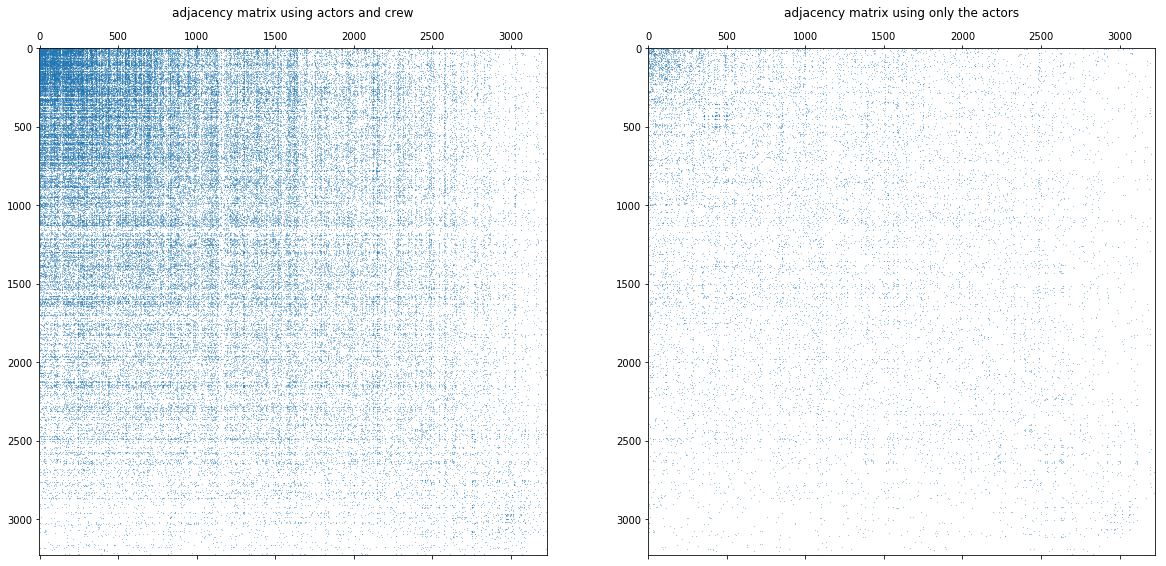

In [31]:
#As both function used to create the adjacency take some time to run, we saved the adjacency and simply load it.

#Used to load the feature dataframe from a file, remove the useless columns and transpose it.
#features_movies=ldata.load_features();

#Used to create the adjacency matrix from the features
#As the function takes some time to run, we saved the adjacency matrix and are simply loading it.
#adjacency_test=ldata.make_adjacency_from_feature_matrix(features_movies)


plt.figure(figsize=(20, 10))

plt.subplot(121)
adjacency_actors_crew=np.load('./data/adjacency_actors_crew.npy')
plt.spy(adjacency_actors_crew, markersize=0.1)
plt.title('adjacency matrix using actors and crew')


plt.subplot(122)
adjacency_actors_crew=np.load('./data/adjacency_actors_only.npy')
plt.spy(adjacency_actors_crew, markersize=0.1)
plt.title('adjacency matrix using only the actors')

For the rest of the project, we decided to use the adjacency matrix with actors and the crew, however as both adjacency matrices were saved they can be easily swapped if needed. We then created a graph using this adjacency matrix. As shown below, there are many unconnected movies (338 connected componenents in total), so we decided to use the giant component for the next steps.

The number of connected components is 338


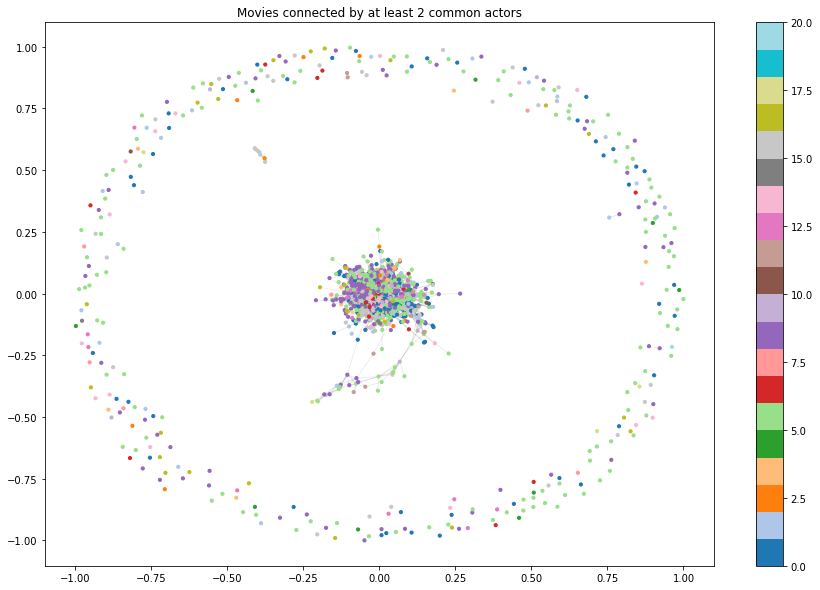

In [34]:
#We decided to use the adjacency with actors and the crew, but the one with actors only can be used if needed.
#adjacency_actors=np.load('./data/adjacency_actors_only.npy')
adjacency_actors=np.load('./data/adjacency_actors_crew.npy')

G = nx.from_numpy_matrix(adjacency_actors)
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
labels = movies['genres'].iloc[np.sort(nx.nodes(G_test))]

fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(G, coords, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(G, coords, alpha=0.1, width=0.7)
plt.title('Movies connected by at least 2 common actors, the colors represent the different movie genres')
plt.colorbar(im);
fig.savefig('./pictures/graph1.png')

We plot the giant component and see that it contains 2883 movies. We also plot it with only the three most represented movie genres (Action, Drama and Comedy)

The number of nodes is is 2883


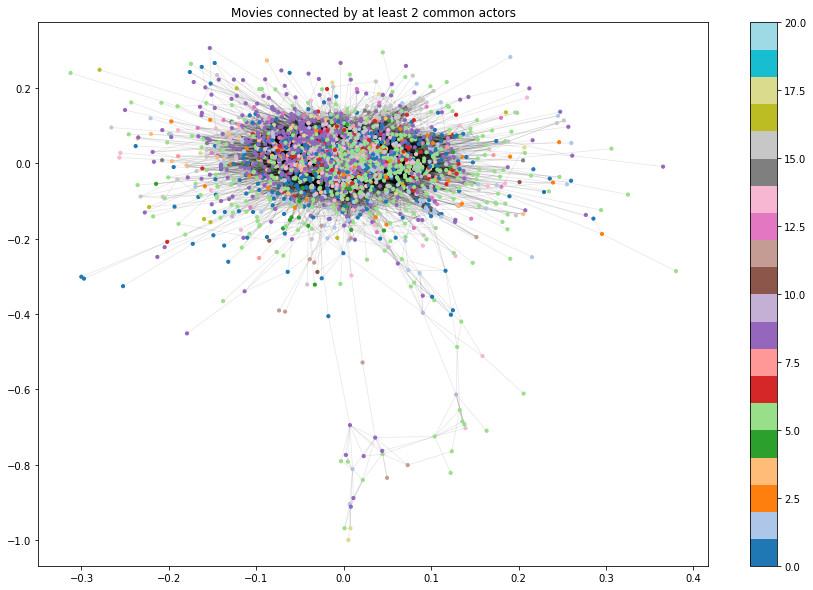

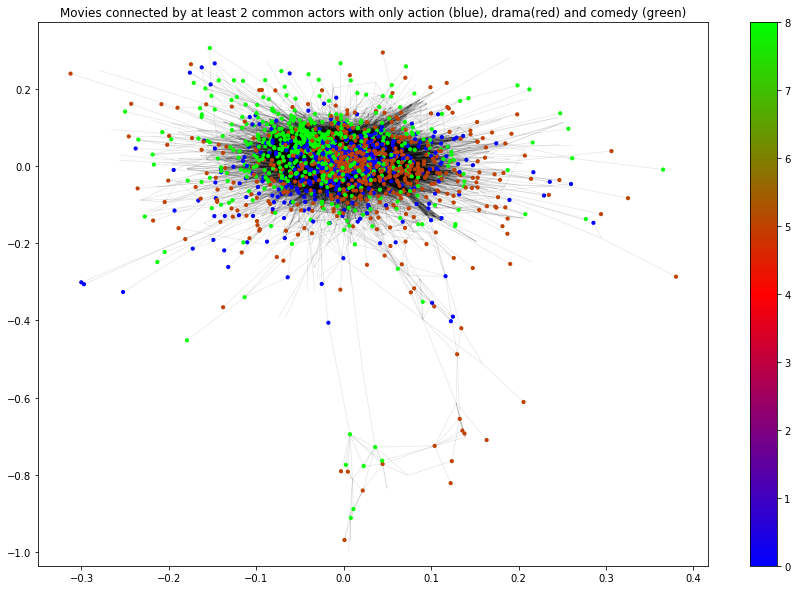

In [36]:
Gc = max(nx.connected_component_subgraphs(G), key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.

print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = movies['genres'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component of the movies connected by at least 2 common actors')
plt.colorbar(im);
fig.savefig('./pictures/graph1.png')

#We mask the movies which do no belong to the 3 most represented genres
masked_labels=labels.copy()
masked_labels[masked_labels<30]=30
masked_labels[labels==0]=0
masked_labels[labels==5]=5
masked_labels[labels==8]=8
masked_labels[masked_labels>10]=np.nan

#action = 0 = blue
#drama = 5 = red
#comedy = 8= green

fig2=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=masked_labels, cmap='brg',vmin=0, vmax=8)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Movies connected by at least 2 common actors with only action (blue), drama(red) and comedy (green)')
plt.colorbar(im);
fig2.savefig('./pictures/graph2.png')


We can then use this graph to represen different signal, for example the vote average of each movie

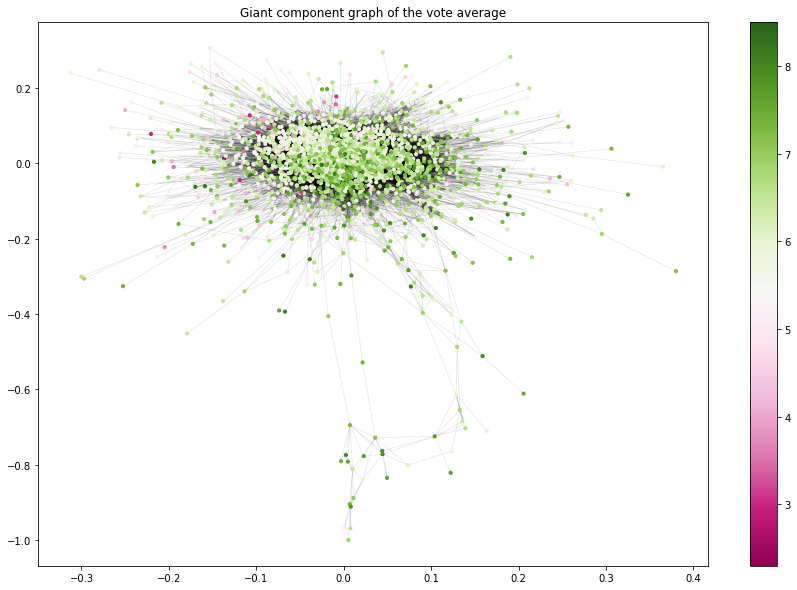

In [39]:
labels = movies['vote_average'].iloc[np.sort(nx.nodes(Gc))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='PiYG')
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component graph of the vote average')
plt.colorbar(im);

## 3 - Separation into decades

In [ ]:
numberOfDecades = 6

moviesFilteredByYears = []

for i in range(numberOfDecades):
    decade = 1960 + i*10
    decadeEnd = decade + 10
    moviesFilteredByYears.append(ldata.filter_movies_by_years(movies, pd.to_datetime(f'{decade}-01-01').date(), pd.to_datetime(f'{decadeEnd}-01-01').date()))

In [ ]:
adjacency=np.load('./data/adjacency_actors_crew.npy')
plt.spy(adjacency, markersize=0.1)
n_edges =  np.count_nonzero(adjacency)/2
print('number of edges: {}'.format(n_edges))

G=nx.from_numpy_matrix(adjacency)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()

In [ ]:
adjacency=np.load('./data/adjacency_actors_only.npy')
plt.spy(adjacency, markersize=0.1)
n_edges =  np.count_nonzero(adjacency)/2
print(n_edges)

In [ ]:
#Ici on fait le graph des films liés par les acteurs ET LE CREW
#On voit que qu'il y a beaucoup de films "seuls", donc dans la prochaine celle on fait pareil mais avec le giant component
adjacency=np.load('./data/adjacency_actors_crew.npy')
moviesFilteredByYears
for i in range(numberOfDecades):
    
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.spy(adjacency_decade_filtered, markersize=2)
    plt.title('adjacency of the decade ACTORS AND CREW')
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    
    plt.subplot(122)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('graph of the decade ACTORS AND CREW')
    plt.colorbar(im);

In [ ]:
#ICI LES MEME GRAPHS MAIS AVEC LE GIANT COMPONENT
for i in range(numberOfDecades):
    
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    plt.subplot(121)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS AND CREW')
    plt.colorbar(im);
    
    Gc_decade = max(nx.connected_component_subgraphs(G_decade), key=len)
    nb_edges_gc=Gc_decade.number_of_edges()
    nb_nodes_gc=Gc_decade.number_of_nodes()
    coords_decade_Gc = nx.spring_layout(Gc_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(Gc_decade))]
    plt.subplot(122)
    im=nx.draw_networkx_nodes(Gc_decade, coords_decade_Gc, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(Gc_decade, coords_decade_Gc, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS ONLY, with {} edges and {} nodes'.format(nb_edges_gc,nb_nodes_gc))
    plt.colorbar(im);

In [ ]:
#Ici on fait le graph des films liés par les acteurs selon la décade
#On voit que qu'il y a beaucoup de films "seuls", donc dans la prochaine celle on fait pareil mais avec le giant component
adjacency=np.load('./data/adjacency_actors_only.npy')
moviesFilteredByYears
for i in range(numberOfDecades):
    
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.spy(adjacency_decade_filtered, markersize=2)
    plt.title('adjacency of the decade ACTORS ONLY')
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    
    plt.subplot(122)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('graph of the decade ACTORS ONLY')
    plt.colorbar(im);

In [ ]:
#ICI LES MEME GRAPHS MAIS AVEC LE GIANT COMPONENT
for i in range(numberOfDecades):
    
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    plt.subplot(121)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS ONLY')
    plt.colorbar(im);
    
    
    Gc_decade = max(nx.connected_component_subgraphs(G_decade), key=len)
    nb_edges_gc=Gc_decade.number_of_edges()
    nb_nodes_gc=Gc_decade.number_of_nodes()
    coords_decade_Gc = nx.spring_layout(Gc_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(Gc_decade))]
    plt.subplot(122)
    im=nx.draw_networkx_nodes(Gc_decade, coords_decade_Gc, node_size=10,node_color=labels, cmap='tab20', vmin=0, vmax=20)
    nx.draw_networkx_edges(Gc_decade, coords_decade_Gc, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS ONLY, with {} edges and {} nodes'.format(nb_edges_gc,nb_nodes_gc))
    plt.colorbar(im);
    
    
    #normalized_laplacian=nx.normalized_laplacian_matrix(Gc_decade)
    #fiedler=nx.fiedler_vector(Gc_decade)
    #coords = nx.spring_layout(Gc_decade,k=0.03)  # Force-directed layout.
    #e, U = np.linalg.eigh(normalized_laplacian)
    #plt.figure(figsize=(10, 10))
    #plt.subplot(122)
    #im=nx.draw_networkx_nodes(Gc_decade, coords, node_size=10, node_color=fiedler)
    #nx.draw_networkx_edges(Gc_decade, coords, alpha=0.1, width=0.5)
    #plt.title('Fiedler Vector')
    #plt.colorbar(im)
    

In [ ]:
#(adjacency, movies_by_budget) = ldata.make_budget_based_adjacency(movies);

adjacenciesFilteredByYears = []
moviesByBudgetFilteredByYears = []
genreOfMoviesFilteredByYears=[]
graphsFilteredByYears = []

for moviesData in moviesFilteredByYears:
    (adjacency, moviesByBudget,genreOfMovies) = ldata.make_budget_based_adjacency(moviesData,list_of_genres_id);
    adjacenciesFilteredByYears.append(adjacency);
    moviesByBudgetFilteredByYears.append(moviesByBudget)
    genreOfMoviesFilteredByYears.append(genreOfMovies)
    graphsFilteredByYears.append(pg.graphs.Graph(adjacency))



In [ ]:
voteAvrgFtFilteredByYears = []
voteAvrgFilteredByYears = []

for i in range(len(graphsFilteredByYears)):
    voteAvrgFilteredByYears.append((moviesByBudgetFilteredByYears[i])['vote_average'].copy())
    (graphsFilteredByYears[i]).compute_fourier_basis()
    voteAvrgFtFilteredByYears.append(graphsFilteredByYears[i].gft((voteAvrgFilteredByYears[i]).values))

In [ ]:
#find the correlation between parameters
for i in range(len(graphsFilteredByYears)):
    plt.figure(figsize=(5, 5))
    data= moviesByBudgetFilteredByYears[i].loc[:, ['budget', 'revenue','vote_average','popularity','ROI']]
    sns.heatmap(data=data.corr(),annot=True)

In [ ]:
i = 0
GCgraphsFilteredByYears=[]
CoordsSpringFilteredByYears=[]

for G in graphsFilteredByYears:  
    #creations des coordonées des giant component
    full_G = nx.from_numpy_matrix(adjacenciesFilteredByYears[i])
    Gc = max(nx.connected_component_subgraphs(full_G), key=len)
    adjacency= nx.to_numpy_array(Gc)
    GCgraphsFilteredByYears.append(Gc)
    CoordsSpringFilteredByYears.append(nx.spring_layout(Gc,k=0.03))
    
    i = i+1

In [ ]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    labels = genreOfMoviesFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Genre of movies')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('budget')
    plt.colorbar(im);
        
    i=i+1
    

In [ ]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['revenue'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Revenue')
    plt.colorbar(im);
        
    i=i+1

In [ ]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['vote_average'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='RdYlGn')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1

In [ ]:
#SUCCESS OF A MOVIE IF THE ROI>1 ? --> plot the success 
#on peut essayer de voir à quel point le success rate est "smooth" sur différents graphs --> 
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['ROI'].iloc[np.sort(nx.nodes(G))]
    labels[labels<0]=0
    labels[labels>0]=1
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='RdYlGn')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1